In [41]:
import numpy as np
import cupy as cp
import h5py
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import remove_outliers
##!jupyter nbconvert --to script config_template.ipynb
import sys

In [42]:
n = 2048  # object size in each dimension
pad = n//4
npos= 1

detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 1.286e-3
z1 = np.tile(5.5e-3-sx0, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

# sample size after demagnification
ne = 2048//(2048//n)+2*pad#1024//(2048//n)#2*pad
show = True
lam1 = 1e-1
lam2 = 0
gpu = 0
frame=True
prbframe=True
pad = n//4
gltype='lap'

# lam1=float(sys.argv[1])
# lam2=float(sys.argv[2])
# gpu = int(sys.argv[6])
# frame = sys.argv[4]=='True'
# prbframe = sys.argv[5]=='True'
# pad = int(sys.argv[6])
# gltype = sys.argv[7]
# gpu = int(sys.argv[8])

cp.cuda.Device(gpu).use()

n0=n
ne0=ne
pad0=pad
voxelsize0=voxelsize

flg = f'{n}'
path = f'/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/SiemensLH_010nm_nfp_02/'
path_ref = f'/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/SiemensLH_010nm_nfp_02/'
path_out = f'/data/vnikitin/ESRF/ID16A/20240924_rec2/SiemensLH/SiemensLH_010nm_nfp_02_reg_{gltype}_{frame}_{prbframe}_{lam1:1.1e}_{lam2:1.1e}_{n}_{pad}'

In [43]:

with h5py.File(f'{path_ref}ref_0000.h5') as fid:
    ref0 = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File(f'{path}/dark_0000.h5') as fid:
    dark0 = fid['/entry_0000/measurement/data'][:].astype('float32')

In [44]:
import scipy.ndimage as ndimage
def remove_outliers(data, dezinger, dezinger_threshold):    
    res = data.copy()
    if (int(dezinger) > 0):
        w = int(dezinger)
        # print(data.shape)
        fdata = ndimage.median_filter(data, [1,w, w])
        print(np.sum(np.abs(data-fdata)>fdata*dezinger_threshold))
        res[:] = np.where(np.abs(data-fdata)>fdata*dezinger_threshold, fdata, data)
    return res
import dxchange
# dxchange.write_tiff(data0[0],'/data/data.tiff',overwrite=True)

18


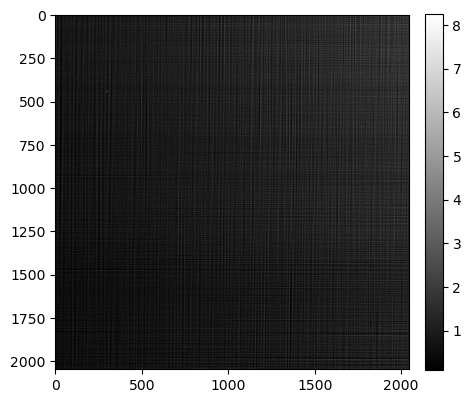

In [51]:
ref = ref0.copy()
dark = dark0.copy()
dark = np.mean(dark,axis=0)[np.newaxis]
ref = np.mean(ref,axis=0)[np.newaxis]
ref-=dark
ref/=np.mean(ref)    
ref[:] = remove_outliers(ref[:], 3, 0.8)     

mshow(ref[0],show)

# Init data sizes and parametes of the PXM of ID16A

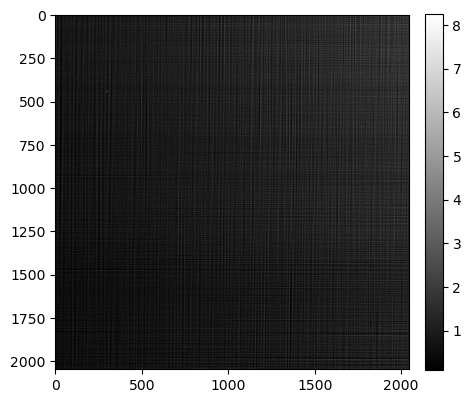

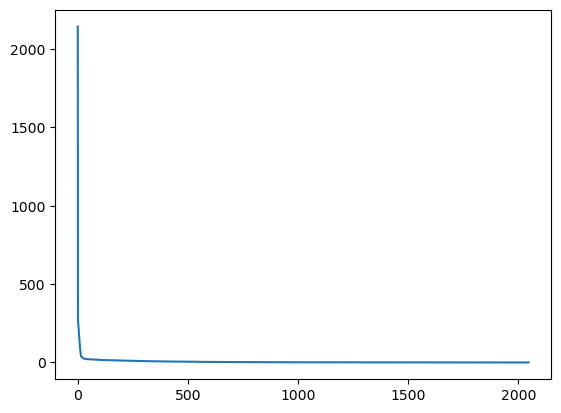

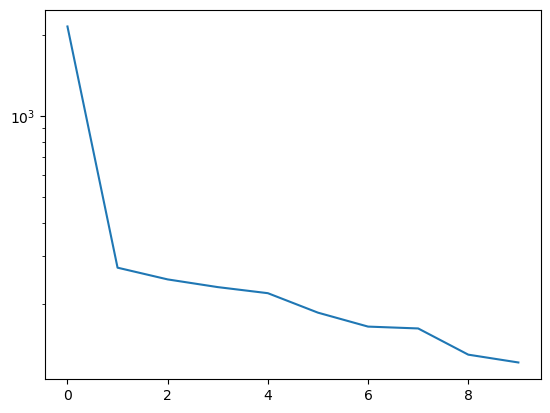

/tmp/ipykernel_287861/2765161595.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.imshow((np.abs(data-data_new)),cmap='gray',vmax=0.1)


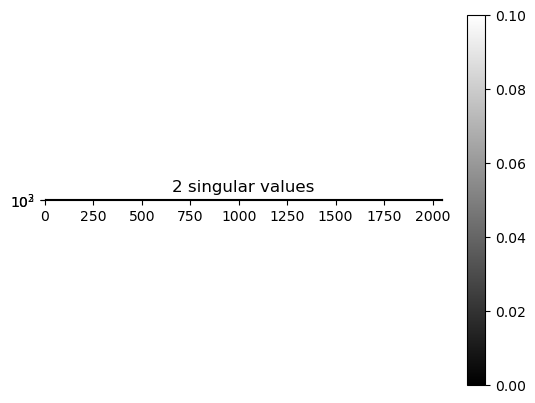

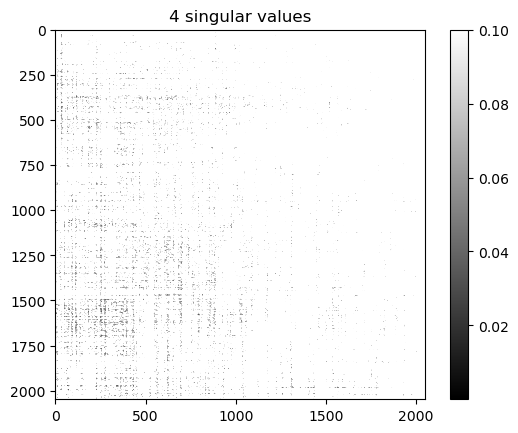

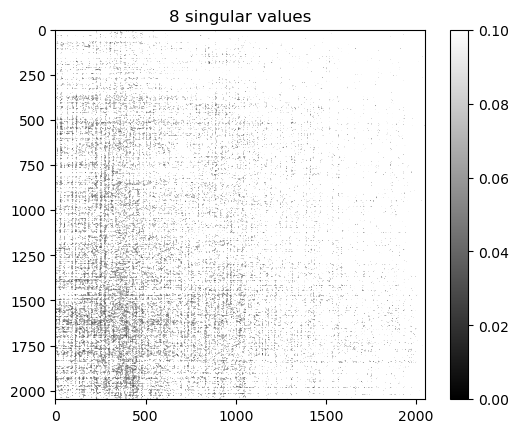

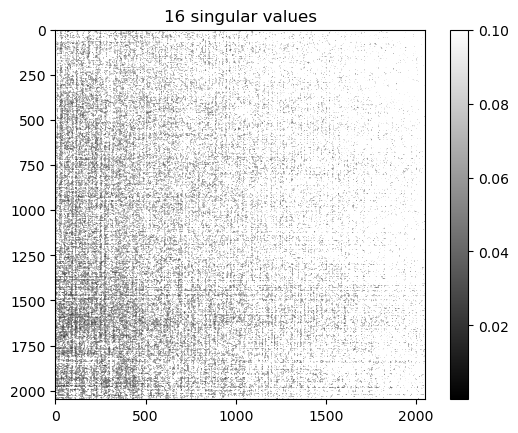

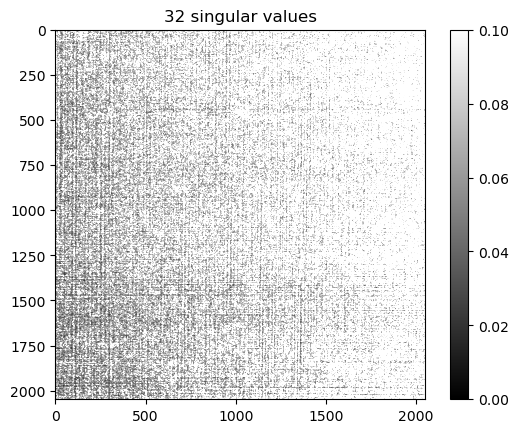

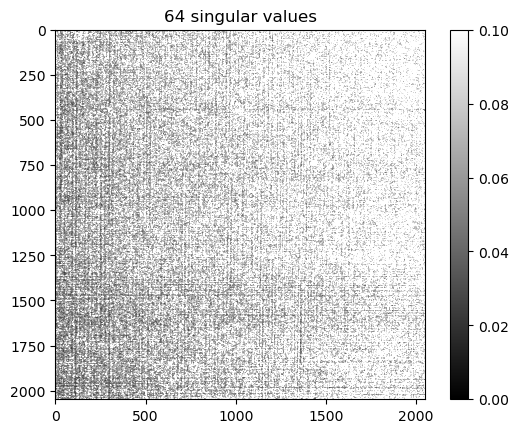

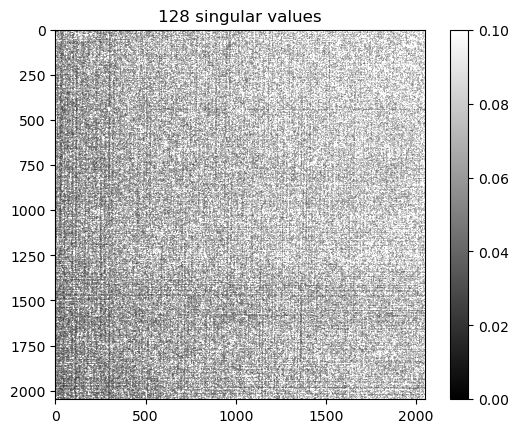

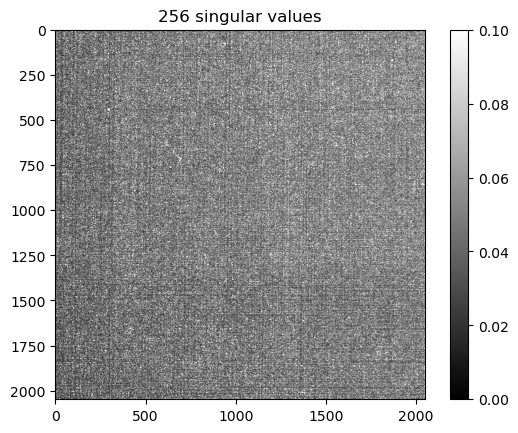

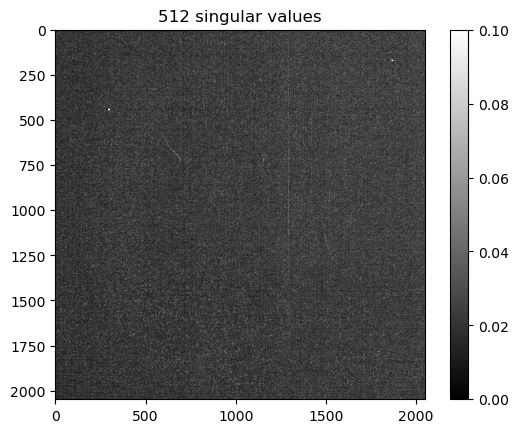

In [ ]:
nn = 512
data = ref[0,ref.shape[1]//2-nn:ref.shape[1]//2+nn,ref.shape[1]//2-nn:ref.shape[1]//2+nn]
mshow(data,True)

U, S, Vh = np.linalg.svd(data)
plt.plot(S)
plt.show()
plt.yscale('log')
plt.plot(S[:10])
plt.show()
plt.yscale('log')

for k in 2**np.arange(1,10):    
    S1=S.copy()
    S1[k:] = 0
    data_new = (U@np.diag(S1))@Vh
    plt.imshow((np.abs(data-data_new)),cmap='gray',vmax=0.3)
    plt.colorbar()
    plt.title(f'{k} singular values')
    plt.show()
    # mshow_complex(data+1j*data_new,True,vmax=3,vmin=0)
    # mshow((np.abs(data-data_new)),True)


## Read data

In [5]:
with h5py.File(f'{path}SiemensLH_010nm_nfp_020000.h5') as fid:
    data0 = fid['/entry_0000/measurement/data'][:npos].astype('float32')
with h5py.File(f'{path_ref}ref_0000.h5') as fid:
    ref0 = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File(f'{path}/dark_0000.h5') as fid:
    dark0 = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File(f'{path}SiemensLH_010nm_nfp_020000.h5','r') as fid:
    spz = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spz']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize
    spy = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spy']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize
data0 = data0[np.newaxis]

shifts_code0 = np.zeros([1,npos,2],dtype='float32')
shifts_code0[:,:,1] = spy[:npos]
shifts_code0[:,:,0] = -spz[:npos]

In [6]:
import scipy.ndimage as ndimage
def remove_outliers(data, dezinger, dezinger_threshold):    
    res = data.copy()
    if (int(dezinger) > 0):
        w = int(dezinger)
        # print(data.shape)
        fdata = ndimage.median_filter(data, [1,w, w])
        print(np.sum(np.abs(data-fdata)>fdata*dezinger_threshold))
        res[:] = np.where(np.abs(data-fdata)>fdata*dezinger_threshold, fdata, data)
    return res
import dxchange
# dxchange.write_tiff(data0[0],'/data/data.tiff',overwrite=True)

18
24
18
19
16
25
24
17
23
17
19
17
21
21
16
17
17


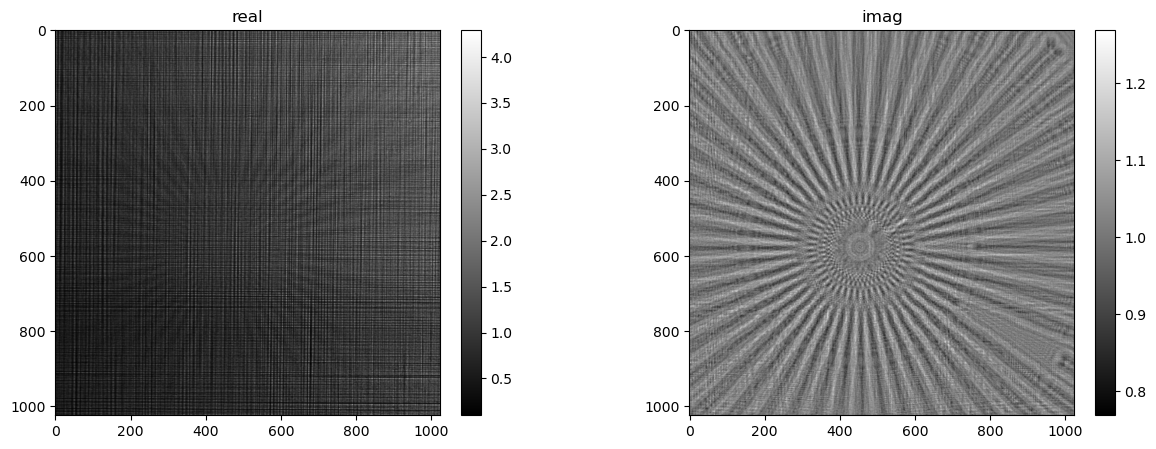

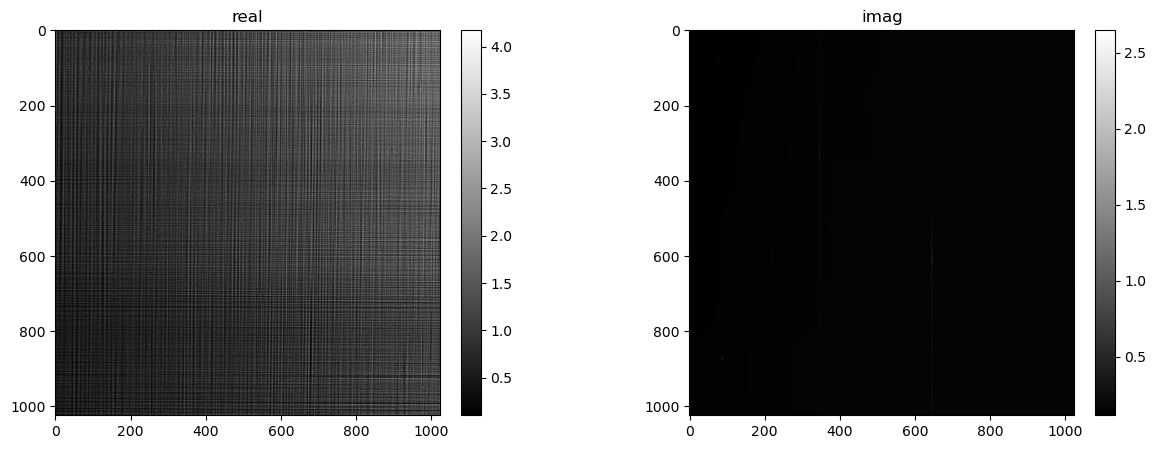

In [7]:
data = data0.copy()
ref = ref0.copy()
dark = dark0.copy()
dark = np.mean(dark,axis=0)[np.newaxis]
ref = np.mean(ref,axis=0)[np.newaxis]
data-=dark
ref-=dark

data[data<0]=0
ref[ref<0]=0
# for k in range(data.shape[1]):
#     data[0,k,data[0,k]>ref[0]] = ref[0,data[0,k]>ref[0]]
data[:,:,1320//3:1320//3+25//3,890//3:890//3+25//3] = data[:,:,1280//3:1280//3+25//3,890//3:890//3+25//3]
ref[:,1320//3:1320//3+25//3,890//3:890//3+25//3] = ref[:,1280//3:1280//3+25//3,890//3:890//3+25//3]
for k in range(npos):
    radius = 3
    threshold = 0.8
    data[:,k] = remove_outliers(data[:,k], radius, threshold)
    
ref[:] = remove_outliers(ref[:], radius, threshold)     
data/=np.mean(ref)
dark/=np.mean(ref)
ref/=np.mean(ref)

data[np.isnan(data)] = 1
ref[np.isnan(ref)] = 1

for k in range(int(np.log2(2048//n))):
    data = (data[:,:,::2]+data[:,:,1::2])*0.5
    data = (data[:,:,:,::2]+data[:,:,:,1::2])*0.5
    ref = (ref[:,::2]+ref[:,1::2])*0.5
    ref = (ref[:,:,::2]+ref[:,:,1::2])*0.5    
    dark = (dark[:,::2]+dark[:,1::2])*0.5
    dark = (dark[:,:,::2]+dark[:,:,1::2])*0.5  

rdata = data/(ref+1e-11)

mshow_complex(data[0,0]+1j*rdata[0,0],show)
mshow_complex(ref[0]+1j*dark[0],show)

# Construct operators


In [8]:
import cupyx.scipy.ndimage as ndimage
def Lop(psi):
    data = cp.zeros([1,npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()
        v = cp.ones(ne,dtype='float32')
        v[:(ne-n)//2] = cp.sin(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        v[-(ne-n)//2:] = cp.cos(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        v = cp.outer(v,v)
        psir*=v
        psir = G(psir, wavelength, voxelsize, distances[i],'constant')        
        data[:, i] = psir[:,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]
    return data

def L1op(q):
    data = q.copy()
    v = cp.ones(ne,dtype='float32')
    v[:(ne-n)//2] = cp.sin(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
    v[-(ne-n)//2:] = cp.cos(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
    v = cp.outer(v,v)
    data*=v
    data = G(data, wavelength, voxelsize, distances[0],'constant')        
    data = data[:,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]
    return data

def L1Top(data):

    q = cp.array(cp.pad(data,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)))).astype('complex64')        
    q = GT(q, wavelength, voxelsize, distances[0],'constant')        
    v = cp.ones(ne,dtype='float32')
    v[:(ne-n)//2] = cp.sin(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
    v[-(ne-n)//2:] = cp.cos(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
    v = cp.outer(v,v)        
    q *= v    
    return q

def LTop(data):
    psi = cp.zeros([1, npos, ne, ne], dtype='complex64')
    for j in range(npos):
        datar = cp.array(cp.pad(data[:, j],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)))).astype('complex64')        
        datar = GT(datar, wavelength, voxelsize, distances[j],'constant')        

        v = cp.ones(ne,dtype='float32')
        v[:(ne-n)//2] = cp.sin(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        v[-(ne-n)//2:] = cp.cos(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        v = cp.outer(v,v)        
        datar *= v

        psi[:,j] += datar
    
    return psi

def Sop(psi,shifts):
    data = cp.zeros([1, npos, ne, ne], dtype='complex64')
    psi = cp.array(psi)
    for j in range(npos):
        psir = psi.copy()
        shiftsr = cp.array(shifts[:, j])
        psir = S(psir, shiftsr,mode='symmetric')
        data[:,j] = psir
    return data

def STop(data,shifts):
    psi = cp.zeros([1, ne, ne], dtype='complex64')

    for j in range(npos):
        datar = cp.array(data[:,j])
        shiftsr = cp.array(shifts[:, j])
        psi += ST(datar,shiftsr,mode='symmetric')
    return psi

def Cop(psi,crop):
    res = psi.copy()
    res[...,crop:res.shape[-1]-crop,crop:res.shape[-1]-crop]=0
    return res

def CTop(psi,crop):
    res = psi.copy()
    res[...,crop:res.shape[-1]-crop,crop:res.shape[-1]-crop]=0
    return res

def Cfop(psi,fcrop):
    return psi[:,fcrop:psi.shape[1]-fcrop,fcrop:psi.shape[2]-fcrop]

def CfTop(psi,fcrop):
    return np.pad(psi,((0,0),(fcrop,fcrop),(fcrop,fcrop)))

# def Gop(psi):
#     res = cp.zeros([2, *psi.shape], dtype='complex64')
#     res[0, :, :, :-1] = psi[:, :, 1:]-psi[:, :, :-1]
#     res[1, :, :-1, :] = psi[:, 1:, :]-psi[:, :-1, :]
#     return res

# def GTop( gr):
#     res = cp.zeros(gr.shape[1:], dtype='complex64')
#     res[:, :, 1:] = gr[0, :, :, 1:]-gr[0, :, :, :-1]
#     res[:, :, 0] = gr[0, :, :, 0]
#     res[:, 1:, :] += gr[1, :, 1:, :]-gr[1, :, :-1, :]
#     res[:, 0, :] += gr[1, :, 0, :]
#     return -res

def Gop(psi):
    if gltype=='lap':
        stencil = cp.array([[0, 1, 0],[1, -4, 1], [0, 1, 0]])
        res = psi.copy()
        res[0] = ndimage.convolve(res[0], stencil)
    else:
        res = cp.zeros([2, *psi.shape], dtype='complex64')
        res[0, :, :, :-1] = psi[:, :, 1:]-psi[:, :, :-1]
        res[1, :, :-1, :] = psi[:, 1:, :]-psi[:, :-1, :]
    return res

def GTop(psi):
    if gltype=='lap':
        stencil = cp.array([[0, 1, 0],[1, -4, 1], [0, 1, 0]])
        res = psi.copy()
        res[0] = ndimage.convolve(res[0], stencil)
    else:
        res = cp.zeros(psi.shape[1:], dtype='complex64')
        res[:, :, 1:] = psi[0, :, :, 1:]-psi[0, :, :, :-1]
        res[:, :, 0] = psi[0, :, :, 0]
        res[:, 1:, :] += psi[1, :, 1:, :]-psi[1, :, :-1, :]
        res[:, 0, :] += psi[1, :, 0, :]
        res = -res
    return res


# adjoint tests
tmp = cp.array(data).copy()
arr1 = (cp.random.random([1,ne,ne])+1j*cp.random.random([1,ne,ne])).astype('complex64')
shifts = cp.array(shifts_code0)
arr2 = Sop(arr1,shifts)
arr3 = STop(arr2,shifts)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = (cp.random.random([1,npos,ne,ne])+1j*cp.random.random([1,npos,ne,ne])).astype('complex64')
arr2 = Lop(arr1)
arr3 = LTop(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = (cp.random.random([1,ne,ne])+1j*cp.random.random([1,ne,ne])).astype('complex64')
arr2 = Gop(arr1)
arr3 = GTop(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = (cp.random.random([1,ne,ne])+1j*cp.random.random([1,ne,ne])).astype('complex64')
arr2 = L1op(arr1)
arr3 = L1Top(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

(24821776-1083.9444580078125j)==
(25135650-9.866788604995236e-05j)
(11081471+0.5135498046875j)==
(11081470+0.00010083755478262901j)
(7848712.5+0.0002593994140625j)==
(7848712.5-2.0089115423616022e-05j)
(692661.1875+0.03849506378173828j)==
(692661.1875+8.812454325379804e-06j)


## Reconstruction with the CG (Carlsson) with Hessians

$$ H(q,\psi,{{x}})=F(J(q)\cdot S_{{x}}(\psi))+\lambda_o\|\nabla C(\psi)\|_2^2+\lambda_p\|\nabla C(q)\|_2^2=\left\||L(M(q,\psi,x))|-d\right\|_2^2+\lambda_o\|\nabla C(\psi)\|_2^2+\lambda_p\|\nabla C(q)\|_2^2+\| |L_1(q)|-d_r\|^2_2
$$
## Reconstruction with the CG (Carlsson) with Hessians

$$ H(q,\psi,{{x}})=\||q\cdot S_{{x}}(\psi)|-d\|_2^2+\lambda_o\|\nabla C(\psi)\|_2^2
$$

## Gradients

#### $$\nabla F=2 \left(L^*\left( L(M(q_0,\psi_0,\boldsymbol{x}_0))-\tilde d\right)\right).$$
#### where $$\tilde d = d \frac{L(M(q_0,\psi_0,\boldsymbol{x}_0))}{|L(M(q_0,\psi_0,\boldsymbol{x}_0))|}$$

#### $$\nabla F_q=2 \left(L^*\left( L_1(q_0)-\tilde d_r\right)\right).$$
#### where $$\tilde d_r = d_r \frac{L_1(q_0)}{|L_1(q_0))|}$$



In [9]:
def gradientF(vars,d):
    (q,psi,x,crop,psifr) = (vars['prb'], vars['psi'], vars['shift'],vars['crop'],vars['psifr'])
    psie = CfTop(psi,crop[1])+psifr
    Lpsi = Lop(Sop(psie,x)*q)
    td = d*(Lpsi/np.abs(Lpsi))
    res = 2*LTop(Lpsi - td)
    return res

##### $$\nabla_{\psi} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=S_{\boldsymbol{x}_{0}}^*\left(\overline{J(q_0)}\cdot \nabla F\right)+ \underline{2\lambda C^T(\nabla^T (\nabla(C(\psi))))}$$

##### $$\nabla_{q} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=J^*\left( \overline{S_{\boldsymbol{x}_{0}}(\psi_0)}\cdot \nabla F\right).$$
##### $$\nabla_{\boldsymbol{x}_0} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=\textsf{Re}\Big(\big( \Big\langle \overline{q_0}\cdot \nabla F,   C(\mathcal{F}^{-1}(-2\pi i \xi_1 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0}))\Big\rangle,\Big\langle \overline{q_0}\cdot \nabla F,C(\mathcal{F}^{-1}(-2\pi i \xi_2 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0})) \Big\rangle\big)\Big)_{k=1}^K. $$




In [10]:
def gradientpsi(psi,q,x,gradF,lam,crop):
    return Cfop(STop(np.conj(q)*gradF,x),crop[1])+2*lam[0]*GTop(CTop(Cop(Gop(psi),crop[0]),crop[0]))

def gradientq(psi,psifr,q,x,dr,gradF,lam,crop):
    Lq = L1op(q)
    td = dr*(Lq/np.abs(Lq))    
    psie = CfTop(psi,crop[1])+psifr
    res = np.sum(np.conj(Sop(psie,x))*gradF,axis=1)
    res += 2*L1Top(Lq - td)
    res += 2*lam[1]*GTop(CTop(Cop(Gop(q),crop[0]),crop[0]))
    return res

def gradientx(psi,psifr,q,x,gradF,crop):
    gradx = cp.zeros([1,npos,2],dtype='float32')    
    xi1 = cp.fft.fftfreq(ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    psir = CfTop(psi,crop[1])+psifr    
    for j in range(npos):        
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))      
        #print(pp.shape,xi1.shape,psir.shape)              
        t = cp.fft.ifft2(pp*xi1*cp.fft.fft2(psir))
        gradx[:,j,0] = -2*np.pi*imdot(gradF[:,j],q*t,axis=(1,2))    
    
    for j in range(npos):        
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))                    
        
        t = cp.fft.ifft2(pp*xi2*cp.fft.fft2(psir))
        gradx[:,j,1] = -2*np.pi*imdot(gradF[:,j],q*t,axis=(1,2))    

    return gradx

    
def gradients(vars,d,dr,gradF):
    (q,psi,x,rho,lam,crop,psifr) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['lam'],vars['crop'],vars['psifr'])
    grads = {}
    
    grads['psi'] = rho[0]*gradientpsi(psi,q,x,gradF,lam,crop)
    grads['prb'] = rho[1]*gradientq(psi,psifr,q,x,dr,gradF,lam,crop)
    grads['shift'] = rho[2]*gradientx(psi,psifr,q,x,gradF,crop)
    return grads



##### $$\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(y)}\overline{L(z)})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L(y)))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(z))) \right\rangle$$
##### $$l_0=L(x_0)/|L(x_0)|$$
##### $$d_0=d/|L(x_0)|$$


In [11]:
def hessianF(hpsi,hpsi1,hpsi2,data):
    Lpsi = Lop(hpsi)        
    Lpsi1 = Lop(hpsi1)
    Lpsi2 = Lop(hpsi2)    
    l0 = Lpsi/np.abs(Lpsi)
    d0 = data/np.abs(Lpsi)
    v1 = np.sum((1-d0)*reprod(Lpsi1,Lpsi2))
    v2 = np.sum(d0*reprod(l0,Lpsi1)*reprod(l0,Lpsi2))        
    return 2*(v1+v2)

def hessianFq(q,dq1,dq2,dr):
    Lq = L1op(q)        
    Lq1 = L1op(dq1)
    Lq2 = L1op(dq2)    
    l0 = Lq/np.abs(Lq)
    d0 = dr/np.abs(Lq)
    v1 = np.sum((1-d0)*reprod(Lq1,Lq2))
    v2 = np.sum(d0*reprod(l0,Lq1)*reprod(l0,Lq2))        
    return 2*(v1+v2)

##### $D T_c|_{{{z}_0}}(\Delta {z})=-2\pi iC\Big(\mathcal{F}^{-1}\big({\Delta z \cdot \xi}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{c}({\xi})\big)\Big)=-2\pi i C\Big(\mathcal{F}^{-1}\big((\Delta z_1 {\xi_1}+\Delta z_2 {\xi_2}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{c}({\xi})\big)\Big)$
##### $ D^2{T_c}|_{{{z}_0}}(\Delta{z},\Delta{w})=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z}\cdot\xi)(\Delta{w}\cdot\xi)e^{-2\pi i  {z}_0\cdot {\xi}}\hat{c}))$
##### $=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z_1}\Delta{w_1}\xi_1^2 + (\Delta{z_1}\Delta{w_2}+\Delta{z_2}\Delta{w_1})\xi_1\xi_2+\Delta{z_2}\Delta{w_2}\xi_2^2)\hat{c}))$

In [12]:
def DT(psi,x,dx):
    res = cp.zeros([1,npos,ne,ne],dtype='complex64')
    xi1 = cp.fft.fftfreq(2*ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for j in range(npos):
        psir = cp.pad(psi, ((0, 0), (ne//2, ne//2), (ne//2, ne//2)),'symmetric')
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        dxj = cp.array(dx[:,j,:,np.newaxis,np.newaxis])

        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))    
        xiall = xi1*dxj[:,0]+xi2*dxj[:,1]

        psir = cp.fft.ifft2(pp*xiall*cp.fft.fft2(psir))   

        res[:,j] = -2*np.pi*1j*psir[:, ne//2:-ne//2, ne//2:-ne//2]       
    return res


def D2T(psi,x,dx1,dx2):
    res = cp.zeros([1,npos,ne,ne],dtype='complex64')
    xi1 = cp.fft.fftfreq(2*ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for j in range(npos):
        psir = cp.pad(psi, ((0, 0), (ne//2, ne//2), (ne//2, ne//2)),'symmetric')
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        dx1j = cp.array(dx1[:,j,:,np.newaxis,np.newaxis])
        dx2j = cp.array(dx2[:,j,:,np.newaxis,np.newaxis])

        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))    
        xiall = xi1**2*dx1j[:,0]*dx2j[:,0]+ \
                xi1*xi2*(dx1j[:,0]*dx2j[:,1]+dx1j[:,1]*dx2j[:,0])+ \
                xi2**2*dx1j[:,1]*dx2j[:,1]

        psir = cp.fft.ifft2(pp*xiall*cp.fft.fft2(psir))   

        res[:,j] = -4*np.pi**2*psir[:,ne//2:-ne//2, ne//2:-ne//2]       
    return res


#### $$ DM|_{(q_0,\psi_0,\boldsymbol{x})}(\Delta q, \Delta \psi,\Delta\boldsymbol{x})=$$
#### $$ \Big(\Delta q\cdot T_{\psi_0}({\boldsymbol{x}_{0,k}})+ q_0\cdot \big(T_{\Delta \psi}({\boldsymbol{x}_{0,k}})+  DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k)\big) \Big)_{k=1}^K=$$
#### $$ J(\Delta q)\cdot S_{\boldsymbol{x}_{0,k}}(\psi_0)+ J(q_0)\cdot S_{\boldsymbol{x}_{0}}{(\Delta \psi)}+  \Big(q_0\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k) \Big)_{k=1}^K$$


In [13]:
def DM(psi,q,x,dpsi,dq,dx):
    res = dq*Sop(psi,x)+q*(Sop(dpsi,x)+DT(psi,x,dx))   
    return res

##### $$ D^2M|_{(q_0,\psi_0,\boldsymbol{x})}\big((\Delta q^{(1)}, \Delta \psi^{(1)},\Delta\boldsymbol{x}^{(1)}),(\Delta q^{(2)}, \Delta \psi^{(2)},\Delta\boldsymbol{x}^{(2)})\big)= $$
##### $$\Big( q_0\cdot DT_{\Delta\psi^{(1)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+q_0\cdot DT_{\Delta\psi^{(2)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})+ q_0\cdot D^2{T_\psi}|_{{\boldsymbol{x}_0}}(\Delta\boldsymbol{x}^{(1)},\Delta\boldsymbol{x}^{(2)})+$$
##### $$\Delta q^{(1)}\cdot T_{\Delta \psi^{(2)}}({\boldsymbol{x}_{0,k}})+\Delta q^{(2)}\cdot T_{\Delta \psi^{(1)}}({\boldsymbol{x}_{0,k}})+ $$
##### $$\Delta q^{(1)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+\Delta q^{(2)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})\Big)_{k=1}^K.$$


In [14]:
def D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2):    
    res =  q*DT(dpsi1,x,dx2) + q*DT(dpsi2,x,dx1) + q*D2T(psi,x,dx1,dx2)  
    res += dq1*Sop(dpsi2,x) + dq2*Sop(dpsi1,x) 
    res += dq1*DT(psi,x,dx2) + dq2*DT(psi,x,dx1)
    return res

##### $$\mathcal{H}^G|_{ (q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)=$$
##### $$\Big\langle \nabla F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}, D^2M|_{(q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)\Big\rangle +$$
##### $$\mathcal{H}^F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}\Big(DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)+$$
##### $$+\underline{2\lambda \textsf{Re}\langle \nabla (C (\Delta \psi^{(1)})),\nabla (C( \Delta \psi^{(2)}))\rangle}$$

In [15]:
def calc_beta(vars,grads,etas,d,dr,gradF):
    (q,psi,x,rho,lam,crop,psifr) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['lam'],vars['crop'],vars['psifr'])    
    (dpsi1,dq1,dx1) = (grads['psi']*rho[0], grads['prb']*rho[1], grads['shift']*rho[2])
    (dpsi2,dq2,dx2) = (etas['psi']*rho[0], etas['prb']*rho[1], etas['shift']*rho[2])
    
    # calc first
    gpsi1 = Cop(Gop(dpsi1),crop[0])
    gpsi2 = Cop(Gop(dpsi2),crop[0])

    # new psi
    psi = CfTop(psi,crop[1])+psifr
    dpsi1 = CfTop(dpsi1,crop[1])
    dpsi2 = CfTop(dpsi2,crop[1])

    # continue
    dm1 = DM(psi,q,x,dpsi1,dq1,dx1)
    dm2 = DM(psi,q,x,dpsi2,dq2,dx2)
    d2m1 = D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2)
    d2m2 = D2M(psi,q,x,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    sq = Sop(psi,x)*q
    gq1 = Cop(Gop(dq1),crop[0])
    gq2 = Cop(Gop(dq2),crop[0])

    top = redot(gradF,d2m1)        
    top += hessianF(sq, dm1, dm2,d)    
    top += hessianFq(q, dq1, dq2,dr)    
    top += 2*lam[0]*redot(gpsi1,gpsi2)+2*lam[1]*redot(gq1,gq2)

    bottom = redot(gradF,d2m2)    
    bottom += hessianF(sq, dm2, dm2,d)
    bottom += hessianFq(q,dq2,dq2,dr)
    bottom += 2*lam[0]*redot(gpsi2,gpsi2)+2*lam[1]*redot(gq2,gq2)
    return top/bottom

def calc_alpha(vars,grads,etas,d,dr,gradF):    
    (q,psi,x,rho,lam,crop,psifr) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['lam'],vars['crop'],vars['psifr'])    
    (dpsi1,dq1,dx1) = (grads['psi'], grads['prb'], grads['shift'])
    (dpsi2,dq2,dx2) = (etas['psi'], etas['prb'], etas['shift']) 
    top = -redot(dpsi1,dpsi2)-redot(dq1,dq2)-redot(dx1,dx2)
    
    (dpsi2,dq2,dx2) = (etas['psi']*rho[0], etas['prb']*rho[1], etas['shift']*rho[2])

    #calculate first
    gpsi2 = Cop(Gop(dpsi2),crop[0])
    gq2 = Cop(Gop(dq2),crop[0])

    psi = CfTop(psi,crop[1])+psifr
    dpsi2 = CfTop(dpsi2,crop[1])

    dm2 = DM(psi,q,x,dpsi2,dq2,dx2)
    d2m2 = D2M(psi,q,x,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    sq = Sop(psi,x)*q
    gq2 = Cop(Gop(dq2),crop[0])
    
    bottom = redot(gradF,d2m2)
    bottom += hessianF(sq, dm2, dm2,d)
    bottom += hessianFq(q,dq2,dq2,dr)    
    bottom += 2*lam[0]*redot(gpsi2,gpsi2)
    bottom += 2*lam[1]*redot(gq2,gq2)
    return top/bottom, top, bottom

### Initial guess for reconstruction (Paganin)

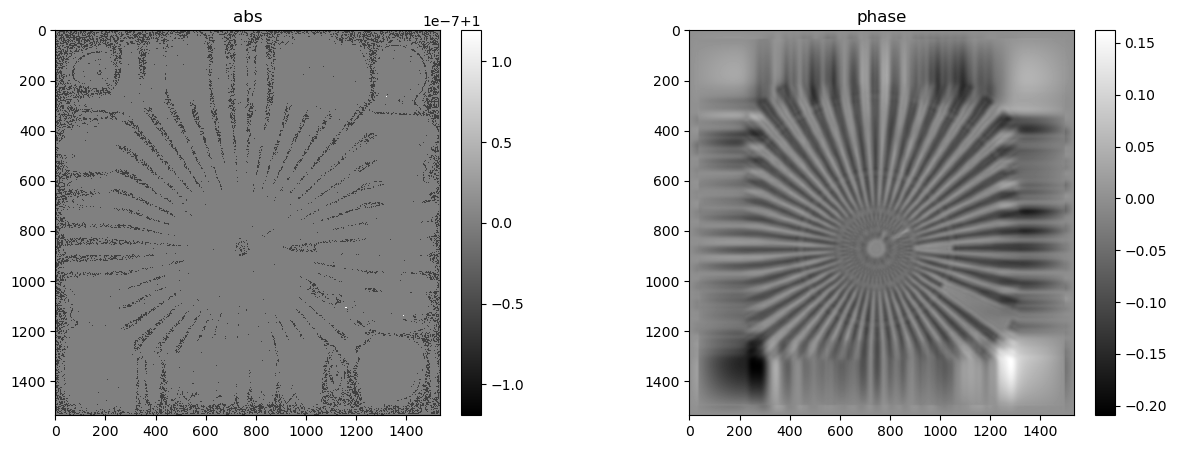

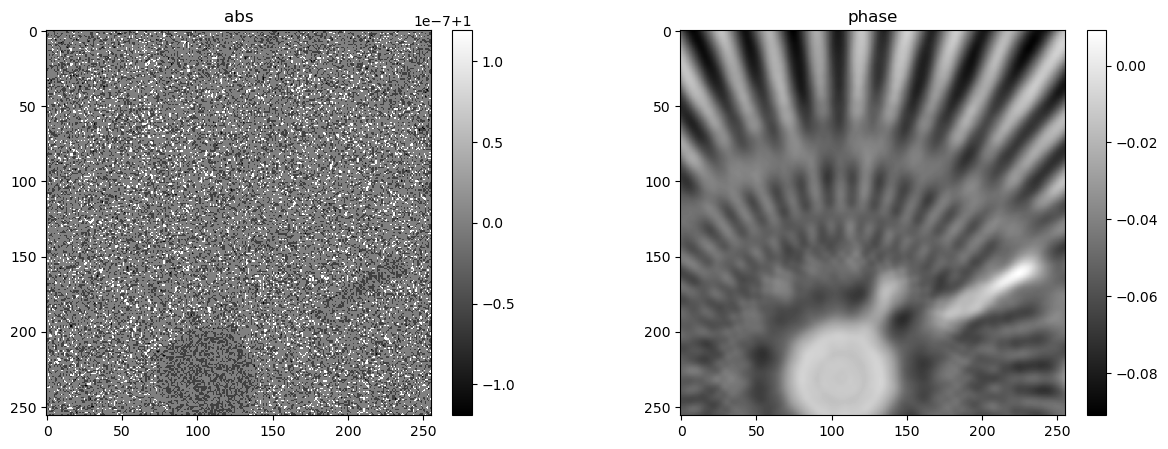

In [16]:
def rec_init(rdata,shifts):
    recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
    recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        rdatar = cp.array(rdata[:,j:j+1])
        r = multiPaganin(rdatar,
                            distances[j:j+1], wavelength, voxelsize,  24.05, 8e-3)    
        rr = r*0+1 # to compensate for overlap
        #r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)))   
        #rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)))   
        shiftsr = cp.array(shifts[:,j])
        recMultiPaganin[:,j] = ST(r,shiftsr).real
        recMultiPaganinr[:,j] = ST(rr,shiftsr).real
        
    recMultiPaganin = np.sum(recMultiPaganin,axis=1)
    recMultiPaganinr = np.sum(recMultiPaganinr,axis=1)

    # avoid division by 0
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

    # compensate for overlap
    recMultiPaganin /= recMultiPaganinr
    v = cp.ones(ne,dtype='float32')
    v[:pad] = np.sin(cp.linspace(0,1,pad)*np.pi/2)
    v[ne-pad:] = np.cos(cp.linspace(0,1,pad)*np.pi/2)
    v = np.outer(v,v)
    recMultiPaganin*=v
    recMultiPaganin = np.exp(1j*recMultiPaganin)

    return recMultiPaganin

rdatap = rdata.copy()
rdatap = np.pad(rdatap,((0,0),(0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')#,constant_values=1)
# mshow(rdatap[0,0],mshow)
rec_paganin = rec_init(rdatap,shifts)
mshow_polar(rec_paganin[0],show)
mshow_polar(rec_paganin[0,ne//2-128:ne//2+128,ne//2-128:ne//2+128],show)

## debug functions

In [17]:
def plot_debug2(vars,etas,top,bottom,alpha,data,ref):
    if show==False:
        return
    (q,psi,x,rho,crop,psifr,lam) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['crop'],vars['psifr'],vars['lam'])
    (dpsi2,dq2,dx2) = (etas['psi'],etas['prb'],etas['shift'])
    npp = 7
    errt = cp.zeros(npp*2)
    errt2 = cp.zeros(npp*2)
    for k in range(0,npp*2):
        psit = psi+(alpha*k/(npp-1))*rho[0]*dpsi2
        qt = q+(alpha*k/(npp-1))*rho[1]*dq2
        xt = x+(alpha*k/(npp-1))*rho[2]*dx2

        gpsit = Cop(Gop(psit),crop[0])
        
        psit = CfTop(psit,crop[1])+psifr
        fpsit = np.abs(Lop(Sop(psit,xt)*qt))-data
        fqt = np.abs(L1op(qt))-ref

        gqt = Cop(Gop(qt),crop[0])        
        errt[k] = np.linalg.norm(fpsit)**2
        errt[k] += np.linalg.norm(fqt)**2
        errt[k] +=lam[0]*np.linalg.norm(gpsit)**2
        errt[k] +=lam[1]*np.linalg.norm(gqt)**2

    gpsi = Cop(Gop(psi),crop[0])

    psi = CfTop(psi,crop[1])+psifr    
    t = alpha*(cp.arange(2*npp))/(npp-1)
    fpsi = np.abs(Lop(Sop(psi,x)*q))-data
    fq = np.abs(L1op(q))-ref
    
    gq = Cop(Gop(q),crop[0])    
    errt2 = np.linalg.norm(fpsi)**2    
    errt2 += np.linalg.norm(fq)**2
    errt2 += lam[0]*np.linalg.norm(gpsi)**2
    errt2 += lam[1]*np.linalg.norm(gq)**2
    errt2 = errt2 -top*t+0.5*bottom*t**2
    
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt.get(),'.')
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt2.get(),'.')
    plt.show()

def plot_debug3(shifts,shifts_init):
    if show==False:
        return
    plt.plot(shifts_init[0,:,0].get()-(shifts[0,:,0].get()),'r.')
    plt.plot(shifts_init[0,:,1].get()-(shifts[0,:,1].get()),'b.')
    plt.show()

def vis_debug(vars,grads,data,i):
    psie = CfTop(vars['psi'],vars['crop'][1])+vars['psifr']
    mshow_polar(psie[0],show)
    mshow_polar(psie[0,ne//2-n//8:ne//2+n//8,ne//2+n//4:ne//2+n//2],show)
    mshow_polar(vars['prb'][0],show)
    dxchange.write_tiff(np.angle(psie).get(),f'{path_out}/crec_psi_angle{flg}/{i:03}',overwrite=True)
    dxchange.write_tiff(np.angle(vars['prb']).get(),f'{path_out}/crec_prb_angle{flg}/{i:03}',overwrite=True)
    dxchange.write_tiff(np.angle(psie[0]).get(),f'{path_out}/crec_psio_angle{flg}/{i:03}',overwrite=True)
    dxchange.write_tiff(np.angle(vars['prb'][0]).get(),f'{path_out}/crec_prbo_angle{flg}/{i:03}',overwrite=True)    
    np.save(f'{path_out}/crec_shift{flg}_{i:03}',vars['shift'])

    
def err_debug(vars, grads, data,ref):    
    (q,psi,x,rho,crop,psifr,lam) = (vars['prb'], vars['psi'], vars['shift'],vars['rho'],vars['crop'],vars['psifr'],vars['lam'])
    gpsi = Cop(Gop(psi),crop[0])

    psi = CfTop(psi,crop[1])+psifr

    fpsi = np.abs(Lop(Sop(psi,x)*q))-data
    fq = np.abs(L1op(q))-ref
    gq = Cop(Gop(q),crop[0])
    err = np.linalg.norm(fpsi)**2    
    err += np.linalg.norm(fq)**2
    err += lam[0]*np.linalg.norm(gpsi)**2
    err += lam[1]*np.linalg.norm(gq)**2

    
   # print(f'gradient norms (psi, prb, shift): {np.linalg.norm(grads['psi']):.2f}, {np.linalg.norm(grads['prb']):.2f}, {np.linalg.norm(grads['shift']):.2f}')                        
    return err

# Main CG loop (fifth rule)

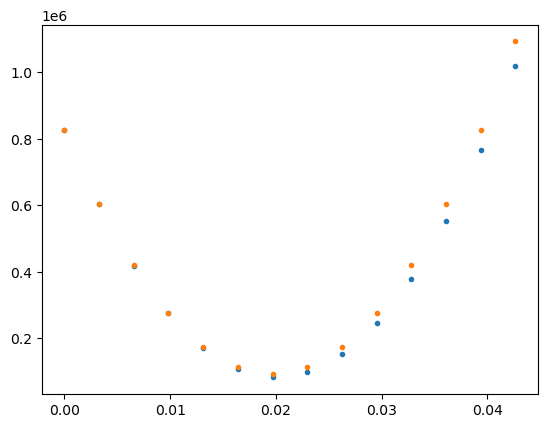

0) alpha=0.01968, [1, 1, 0.03] err=8.17515e+04


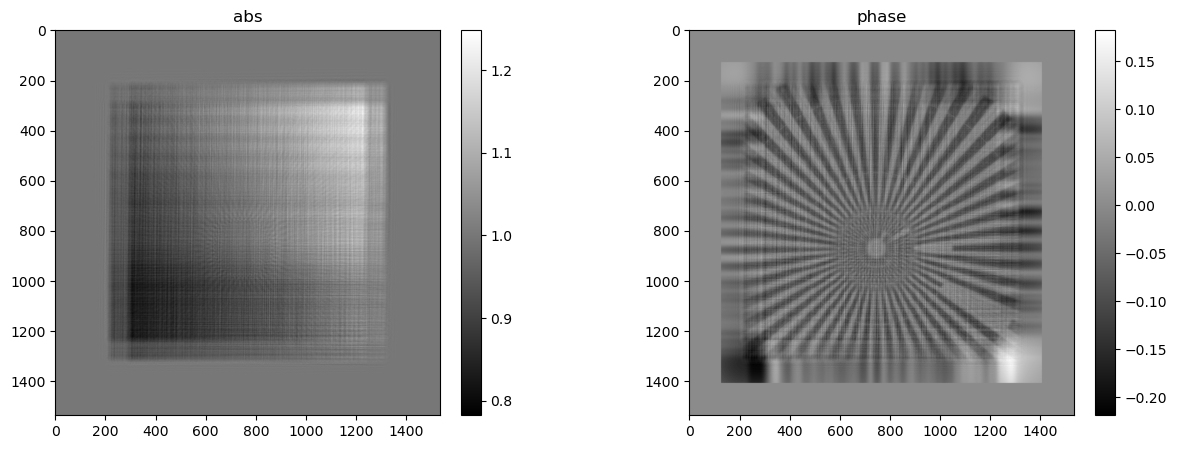

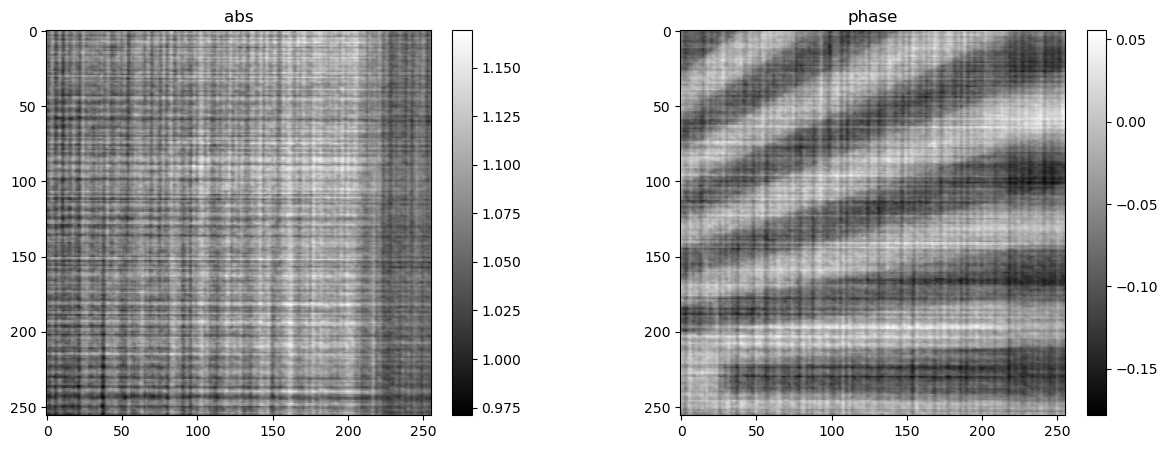

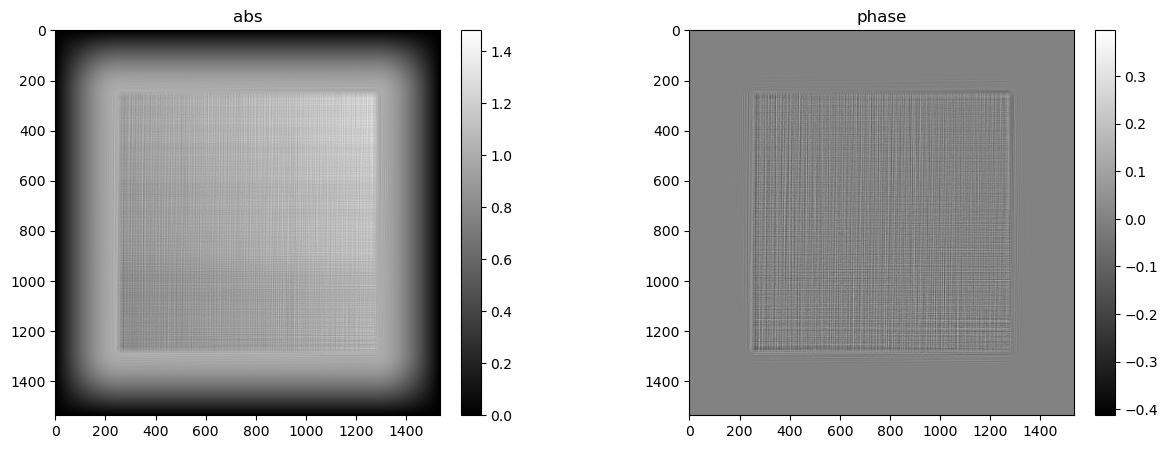

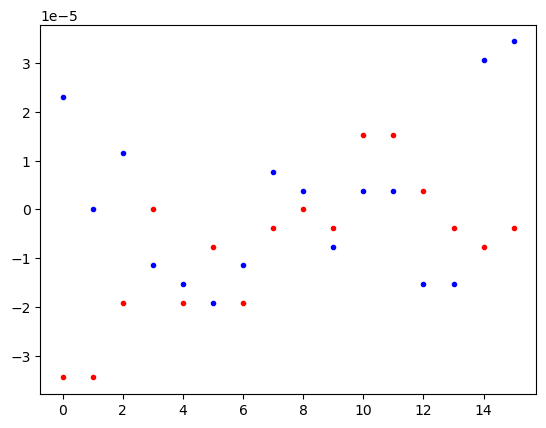

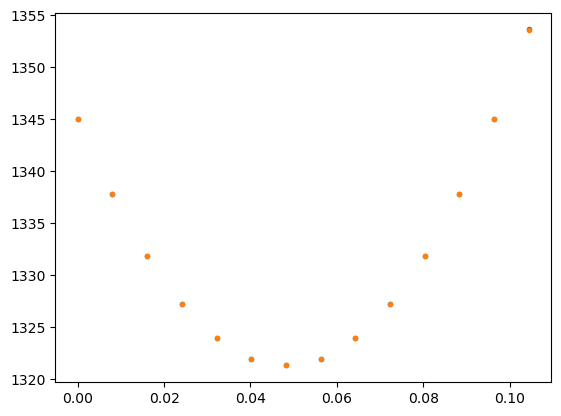

16) alpha=0.04820, [1, 1, 0.03] err=1.32132e+03


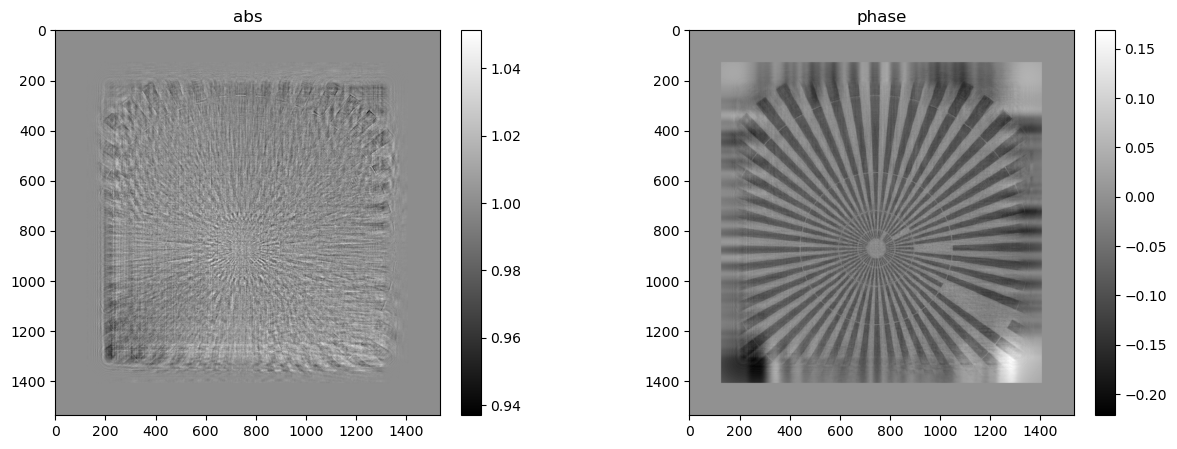

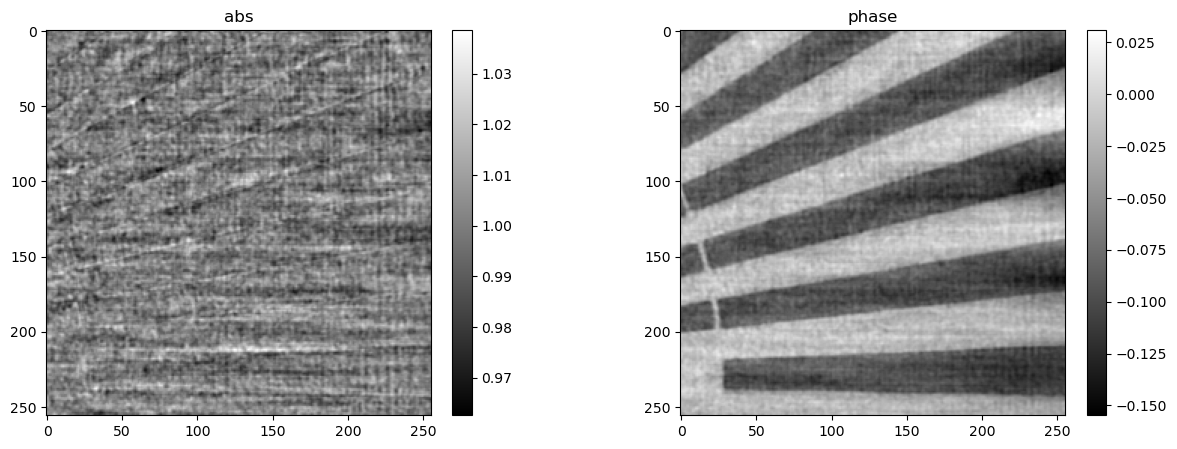

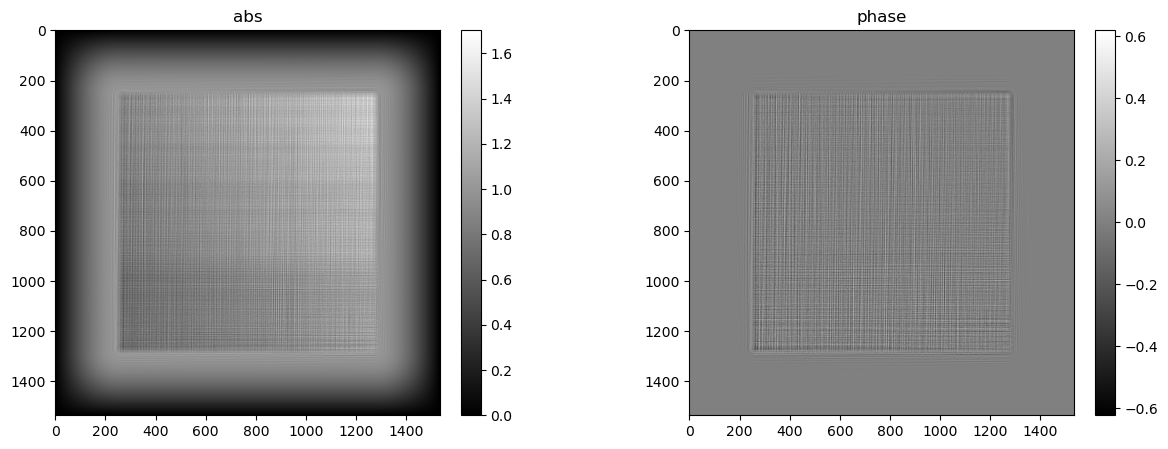

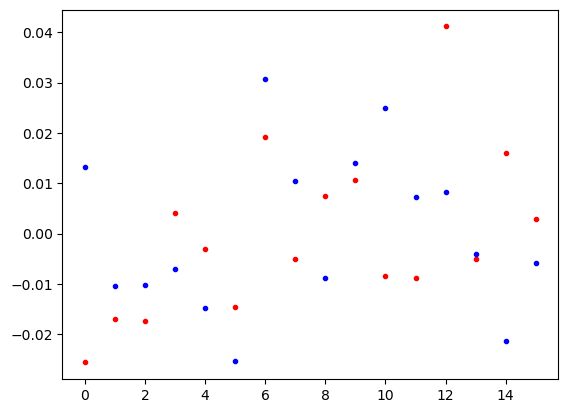

In [ ]:
def cg_holo(data, ref, vars, pars):

    data = np.sqrt(data)    
    ref = np.sqrt(ref)        
    
    erra = cp.zeros(pars['niter'])
    alphaa = cp.zeros(pars['niter'])    
    shifts_init = vars['shift'].copy()
    for i in range(pars['niter']):    
        
        if i==1024:
            vars['crop'][0]=pad//2# = np.array([pad//2,ne//2-n//2-pad//2])        

        gradF = gradientF(vars,data)        
        grads = gradients(vars,data,ref,gradF)
        if i==0 or i==512:
            etas = {}
            etas['psi'] = -grads['psi']
            etas['prb'] = -grads['prb']
            etas['shift'] = -grads['shift']
        else:      
            beta = calc_beta(vars, grads, etas, data, ref, gradF)
            etas['psi'] = -grads['psi'] + beta*etas['psi']
            etas['prb'] = -grads['prb'] + beta*etas['prb']
            etas['shift'] = -grads['shift'] + beta*etas['shift']

        alpha,top,bottom = calc_alpha(vars, grads, etas, data, ref, gradF) 
        if i % pars['vis_step'] == 0:
            plot_debug2(vars,etas,top,bottom,alpha,data,ref)

        vars['psi'] += vars['rho'][0]*alpha*etas['psi']
        vars['prb'] += vars['rho'][1]*alpha*etas['prb']
        vars['shift'] += vars['rho'][2]*alpha*etas['shift']
        
        if i % pars['err_step'] == 0:
            err = err_debug(vars, grads, data,ref)    
            print(f'{i}) {alpha=:.5f}, {vars['rho']} {err=:1.5e}',flush=True)
            erra[i] = err
            alphaa[i] = alpha

        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            vis_debug(vars, grads, data, i)
            if vars['rho'][2]>0:
                plot_debug3(vars['shift'],shifts_init)                         
            
    return vars,erra,alphaa

vars = {}
vars = {}
if frame:
    vars['crop'] = np.array([n//2+pad//2,pad//2])
else:
    vars['crop'] = np.array([n//2+pad,0])
vars['psi'] = rec_paganin[:,vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]
vars['psifr'] = cp.ones([ne,ne],dtype='complex64')
vars['psifr'][vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]=0
vars['prb'] = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')

v = cp.ones(n+2*pad,dtype='float32')
v[:pad] = cp.sin(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
v[-pad:] = cp.cos(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
v = cp.outer(v,v)        
if prbframe:
    vars['prb'] *= v

vars['shift'] = cp.array(shifts)
vars['rho'] = [1,1,0.03]
vars['lam'] = [lam1,lam2]
data_rec = cp.array(data)#p.pad(cp.array(data),((0,0),(0,0),(pad,pad),(pad,pad)))
ref_rec = cp.array(ref)#p.pad(cp.array(data),((0,0),(0,0),(pad,pad),(pad,pad)))
pars = {'niter': 10000, 'err_step': 16, 'vis_step': 16}
vars,erra,alphaa = cg_holo(data_rec, ref_rec, vars, pars)  

In [ ]:
# import scipy as sp

# def _downsample(data, binning):
#     res = data.copy()
#     for k in range(binning):
#         res = 0.5*(res[..., ::2,:]+res[..., 1::2,:])
#         res = 0.5*(res[..., :, ::2]+res[..., :, 1::2])
#     return res

# def _fftupsample(f, dims):
#     paddim = np.zeros([np.ndim(f), 2], dtype='int32')
#     dims = np.asarray(dims).astype('int32')
#     paddim[dims, 0] = np.asarray(f.shape)[dims]//2
#     paddim[dims, 1] = np.asarray(f.shape)[dims]//2
#     fsize = f.size
#     f = sp.fft.ifftshift(sp.fft.fftn(sp.fft.fftshift(
#         f, dims), axes=dims, workers=-1), dims)
#     f = np.pad(f, paddim)
#     f = sp.fft.fftshift(f, dims)
#     f = sp.fft.ifftn(f, axes=dims, workers=-1)
#     f = sp.fft.ifftshift(f, dims)
#     return f.astype('complex64')*(f.size/fsize)

# nlevels = 1
# iters = np.array([4097])
# vis_steps = [64]


# # init with most binned
# n = n0//2**(nlevels-1)
# pad =pad0//2**(nlevels-1)
# ne = ne0//2**(nlevels-1)
# voxelsize = voxelsize0*2**(nlevels-1)

# vars = {}
# vars['crop'] = np.array([n//2+pad//2,pad//2])
# rec = _downsample(cp.asarray(rec_paganin),nlevels-1).astype('complex64')
# vars['psi'] = rec[:,vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]
# vars['psifr'] = cp.ones([ne,ne],dtype='complex64')
# vars['psifr'][vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]=0


# vars['shift'] = shifts/2**(nlevels-1)

# vars['prb'] = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
# vars['rho'] = [1,1,0.03]
# vars['lam'] = [lam1,lam2]


# for level in range(nlevels):
#     print(f'{level=}')
#     data_bin = _downsample(cp.asarray(data),nlevels-level-1)    
#     ref_bin = _downsample(cp.asarray(ref),nlevels-level-1)        
#     pars = {'niter': iters[level], 'err_step': vis_steps[level], 'vis_step': vis_steps[level]}

#     vars,erra,alpha = cg_holo(data_bin,ref_bin, vars, pars)    
#     if level==nlevels-1:
#         break
    
#     vars['psi'] = cp.asarray(_fftupsample(vars['psi'].get(),[1]))
#     vars['psi'] = cp.asarray(_fftupsample(vars['psi'].get(),[2]))
    
#     vars['prb'] = cp.asarray(_fftupsample(vars['prb'].get(),[1]))
#     vars['prb'] = cp.asarray(_fftupsample(vars['prb'].get(),[2]))
    
#     vars['shift']*=2
#     vars['crop']*=2
#     n*=2
#     ne*=2
#     pad*=2
#     voxelsize/=2
#     vars['psifr'] = 1*cp.ones([ne,ne],dtype='complex64')
#     vars['psifr'][vars['crop'][1]:ne-vars['crop'][1],vars['crop'][1]:ne-vars['crop'][1]]=0
    